## 使用逻辑回归模型进行信用卡欺诈检测

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
#matplotlib inline

### 1.读取数据，并打印数据粗略统计信息。

数据集下载地址：https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
data=pd.read_csv('./creditcard.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [3]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# 查看缺失情况 ：无缺失
pd.isnull(data).sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# 去除重复数据
data.drop_duplicates(keep='first',inplace=True)
data.reset_index(inplace=True)
data.shape

(283726, 32)

In [6]:
data.drop(['index','Time'],axis=1,inplace=True)
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2.数据预处理

In [7]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


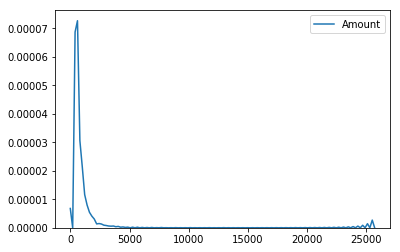

In [8]:
# 绘制原始数据Amount分布
sns.kdeplot(data['Amount'])
plt.show()

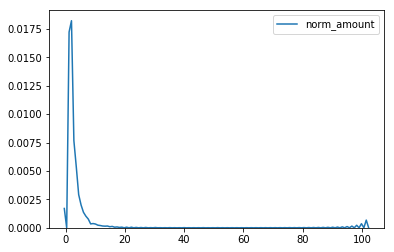

In [9]:
# 对Amount进行标准化处理
ss=StandardScaler()
data['norm_amount']=ss.fit_transform(data['Amount'].values.reshape(-1,1))
sns.kdeplot(data['norm_amount'])
plt.show()

In [10]:
# 去除原特征列
data.drop(['Amount'],axis=1,inplace=True)
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,norm_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244200
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342584
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.158900
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.139886
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073813


### 3.查看样本类别信息

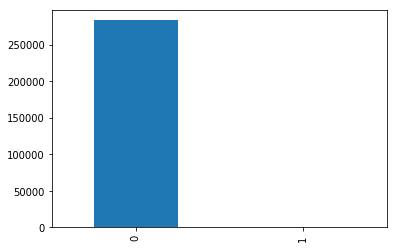

0    283253
1       473
Name: Class, dtype: int64

In [11]:
class_count=pd.value_counts(data['Class'],sort=True)
class_count.plot(kind='bar')
plt.show()
class_count

观察上图可以发现样本类别极不均衡，是因为实际生活中信用卡欺诈行为很少。一般采用过采样与下采样方法处理此类问题。并且我们注重
尽量‘查全’欺诈行为，故要使模型的recall分数尽量高。sklearn中二分类默认pos_label=1，正好对应欺诈标签。


### 4.数据下采样

In [12]:
#得到下采样数据标签

normal_indices=np.array(data[data['Class']==0].index)
fraud_indices=np.array(data[data['Class']==1].index)

num_fraud=len(data[data['Class']==1])
random_normal_indices=np.random.choice(normal_indices,num_fraud,replace=False)
undersample_indices=np.concatenate([random_normal_indices,fraud_indices])
undersample_data=data.loc[undersample_indices,:]

print('undersample fraud num:',len(undersample_data[undersample_data['Class']==1]))
print('undersample normal num:',len(undersample_data[undersample_data['Class']==0]))
print('total undrsample num:',len(undersample_data))

undersample fraud num: 473
undersample normal num: 473
total undrsample num: 946


In [13]:
# 完整数据集特征及标签
x=data.loc[:,data.columns!='Class']
y=data.loc[:,data.columns=='Class']

# 下采样数据集特征及标签
x_undersample=undersample_data.loc[:,undersample_data.columns!='Class']
y_undersample=undersample_data.loc[:,undersample_data.columns=='Class']

### 5.下采样数据模型训练

**一般是在采样数据集上训练，在原数据集上测试。**

In [14]:
# 完整数据集划分
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

# 下采样数据集划分
x_train_undersample,x_test_undersample,y_train_undersample,y_test_undersample=\
    train_test_split(x_undersample,y_undersample,test_size=0.3,random_state=0)

（1）在下采样训练集上训练模型，并在下采样测试集上测试

In [15]:
# 寻找最佳正则化系数
def get_bestC(x_train_data,y_train_data):
    
    kfold=KFold(n_splits=5,random_state=0)
    c_param_range = [0.01, 0.1, 1, 10, 100] #正则化系数
    rec_scores=[]
    
    for c in c_param_range:
        print('*'*15)
        print('c:{}'.format(c))
        clf=LogisticRegression(penalty='l1',C=c,solver='liblinear')
        temp_rec=[]
        for i,(train_indices,valid_indices) in enumerate(kfold.split(x_train_data,y_train_data)):
            train_x,train_y=x_train_data.iloc[train_indices,:],y_train_data.iloc[train_indices,:]
            valid_x,valid_y=x_train_data.iloc[valid_indices,:],y_train_data.iloc[valid_indices,:]
            clf.fit(train_x,train_y)
            pred_y=clf.predict(valid_x)
            rec=recall_score(valid_y,pred_y)
            temp_rec.append(rec)
            print('iter_{}:recall score:{}'.format(i,rec))
        rec_score=np.mean(temp_rec)
        rec_scores.append(rec_score)
        print('mean recall score:{}'.format(rec_score))
    
    best_rec=np.max(rec_scores)
    best_rec_ind=np.argmax(rec_scores)
    best_c=c_param_range[best_rec_ind]
    return best_c,best_rec
             

In [16]:
# 绘制混淆矩阵
def plot_confusion_matrix(mat,classes,title=None):
    plt.imshow(mat,cmap=plt.cm.Blues,alpha=0.3)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(x=j,y=i,s=mat[i,j],va='center',ha='center')

    if title is not None:
        plt.title(title)
    
    tick_marks=range(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.tight_layout()
    plt.xlabel('predicted label')
    plt.ylabel('true label')

***************
c:0.01
iter_0:recall score:0.9705882352941176
iter_1:recall score:0.9846153846153847
iter_2:recall score:0.948051948051948
iter_3:recall score:0.896551724137931
iter_4:recall score:0.9701492537313433
mean recall score:0.953991309166145
***************
c:0.1
iter_0:recall score:0.9117647058823529
iter_1:recall score:0.9076923076923077
iter_2:recall score:0.9090909090909091
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.835820895522388
mean recall score:0.8956323843272467
***************
c:1
iter_0:recall score:0.9264705882352942
iter_1:recall score:0.9230769230769231
iter_2:recall score:0.922077922077922
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.8507462686567164
mean recall score:0.9072329610990263
***************
c:10
iter_0:recall score:0.9264705882352942
iter_1:recall score:0.9538461538461539
iter_2:recall score:0.922077922077922
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.8805970149253731
mean recall score:0.919356956

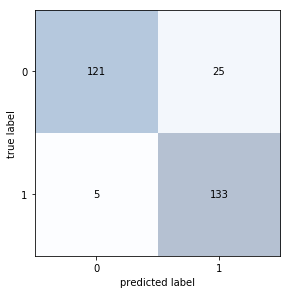

In [17]:
best_c,best_rec=get_bestC(x_train_undersample,y_train_undersample)
print('best model c:{}, best recall score:{}'.format(best_c,best_rec))

clf=LogisticRegression(penalty='l1',C=best_c,solver='liblinear')
clf.fit(x_train_undersample,y_train_undersample)
y_pred_undersample=clf.predict(x_test_undersample)
mat=confusion_matrix(y_test_undersample,y_pred_undersample)
test_rec=recall_score(y_test_undersample,y_pred_undersample)

plot_confusion_matrix(mat,[0,1])
plt.show()
print('undersample test recall score:{}'.format(test_rec))

（2）在下采样训练集上训练模型，并在完整测试集上测试【下采样训练测试流程】

***************
c:0.01
iter_0:recall score:0.9705882352941176
iter_1:recall score:0.9846153846153847
iter_2:recall score:0.948051948051948
iter_3:recall score:0.896551724137931
iter_4:recall score:0.9701492537313433
mean recall score:0.953991309166145
***************
c:0.1
iter_0:recall score:0.9117647058823529
iter_1:recall score:0.9076923076923077
iter_2:recall score:0.9090909090909091
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.835820895522388
mean recall score:0.8956323843272467
***************
c:1
iter_0:recall score:0.9264705882352942
iter_1:recall score:0.9230769230769231
iter_2:recall score:0.922077922077922
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.8507462686567164
mean recall score:0.9072329610990263
***************
c:10
iter_0:recall score:0.9264705882352942
iter_1:recall score:0.9538461538461539
iter_2:recall score:0.922077922077922
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.8805970149253731
mean recall score:0.919356956

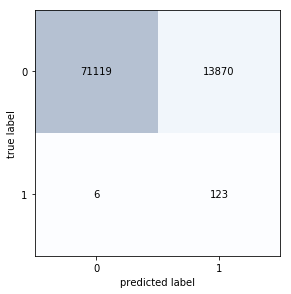

In [18]:
best_c,best_rec=get_bestC(x_train_undersample,y_train_undersample)
print('best model c:{}, best recall score:{}'.format(best_c,best_rec))

clf=LogisticRegression(penalty='l1',C=best_c,solver='liblinear')
clf.fit(x_train_undersample,y_train_undersample)
y_pred=clf.predict(x_test)
mat=confusion_matrix(y_test,y_pred)
test_rec=recall_score(y_test,y_pred)

plot_confusion_matrix(mat,[0,1])
plt.show()
print('test recall score:{}'.format(test_rec))
#虽然recall较高，但是误分太多了

观察上图，虽然recall值较高，但是0误分为1的样本数也比较多，误分率较高。

（3）在完整训练集上训练模型，并在完整测试集上测试


***************
c:0.01
iter_0:recall score:0.5072463768115942
iter_1:recall score:0.5
iter_2:recall score:0.5692307692307692
iter_3:recall score:0.6615384615384615
iter_4:recall score:0.5324675324675324
mean recall score:0.5540966280096715
***************
c:0.1
iter_0:recall score:0.5507246376811594
iter_1:recall score:0.5588235294117647
iter_2:recall score:0.5846153846153846
iter_3:recall score:0.7384615384615385
iter_4:recall score:0.6103896103896104
mean recall score:0.6086029401118915
***************
c:1
iter_0:recall score:0.5507246376811594
iter_1:recall score:0.5882352941176471
iter_2:recall score:0.5846153846153846
iter_3:recall score:0.7692307692307693
iter_4:recall score:0.6103896103896104
mean recall score:0.6206391392069142
***************
c:10
iter_0:recall score:0.5507246376811594
iter_1:recall score:0.5882352941176471
iter_2:recall score:0.6
iter_3:recall score:0.7692307692307693
iter_4:recall score:0.5974025974025974
mean recall score:0.6211186596864346
***************


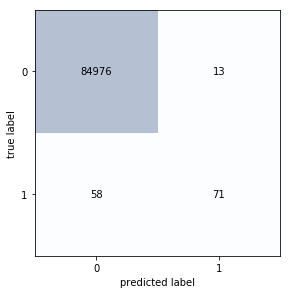

In [19]:
best_c,best_rec=get_bestC(x_train,y_train)
print('best model c:{}, best recall score:{}'.format(best_c,best_rec))

clf=LogisticRegression(penalty='l1',C=best_c,solver='liblinear')
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
mat=confusion_matrix(y_test,y_pred)
test_rec=recall_score(y_test,y_pred)

plot_confusion_matrix(mat,[0,1])
plt.show()
print('test recall score:{}'.format(test_rec))

（4）设置不同的阈值，在下采样训练集上训练模型，并在下采样测试集上测试

***************
c:0.01
iter_0:recall score:0.9705882352941176
iter_1:recall score:0.9846153846153847
iter_2:recall score:0.948051948051948
iter_3:recall score:0.896551724137931
iter_4:recall score:0.9701492537313433
mean recall score:0.953991309166145
***************
c:0.1
iter_0:recall score:0.9117647058823529
iter_1:recall score:0.9076923076923077
iter_2:recall score:0.9090909090909091
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.835820895522388
mean recall score:0.8956323843272467
***************
c:1
iter_0:recall score:0.9264705882352942
iter_1:recall score:0.9230769230769231
iter_2:recall score:0.922077922077922
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.8507462686567164
mean recall score:0.9072329610990263
***************
c:10
iter_0:recall score:0.9264705882352942
iter_1:recall score:0.9538461538461539
iter_2:recall score:0.922077922077922
iter_3:recall score:0.9137931034482759
iter_4:recall score:0.8805970149253731
mean recall score:0.919356956

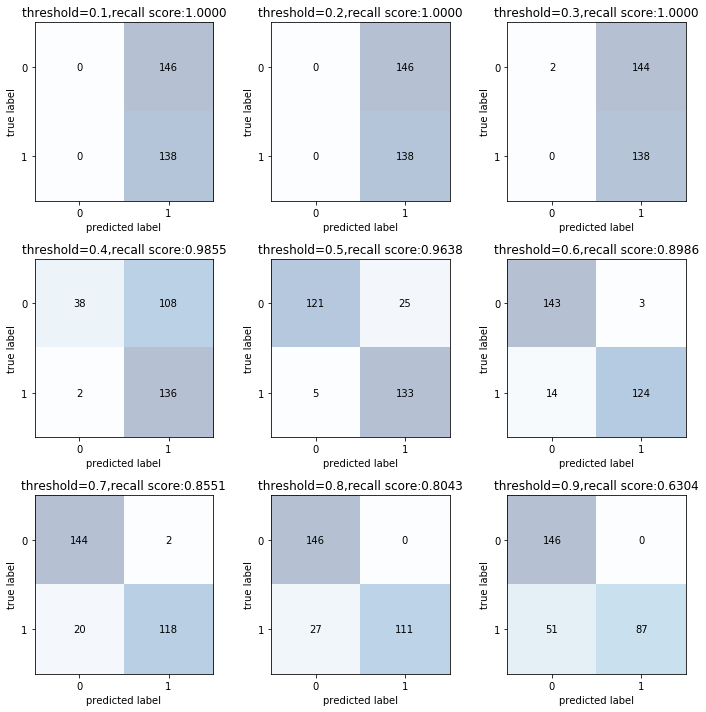

In [20]:
best_c,best_rec=get_bestC(x_train_undersample,y_train_undersample)
print('best model c:{}, best recall score:{}'.format(best_c,best_rec))

clf=LogisticRegression(penalty='l1',C=best_c,solver='liblinear')
clf.fit(x_train_undersample,y_train_undersample)
y_pred_prob_undersample=clf.predict_proba(x_test_undersample)

threshold=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(10,10))
for i,thresh in enumerate(threshold):
    # y_pred_prob_undersample[:,1]则是每个样本预测为 1 的概率
    y_pred_undersample=y_pred_prob_undersample[:,1] > thresh
    mat=confusion_matrix(y_test_undersample,y_pred_undersample)
    
    plt.subplot(3,3,i+1)
    rec_score=recall_score(y_test_undersample,y_pred_undersample)
    title='threshold={},recall score:{:.4f}'.format(thresh,rec_score)
    print(title)
    plot_confusion_matrix(mat,[0,1],title)
plt.show()

从以上的实验可以看出，对于阈值，设置的太大不好，设置的太小也不好，所以阈值设定地越适当，才能使得模型拟合效果越好。

### 5.数据过采样

In [22]:
# 完整数据集特征及标签
x=data.loc[:,data.columns!='Class']
y=data.loc[:,data.columns=='Class']

# 完整数据集划分
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print('train fraud num:',len(y_train[y_train['Class']==1]))
print('train normal num:',len(y_train[y_train['Class']==0]))

train fraud num: 344
train normal num: 198264


In [23]:
#SMOTE过采样
oversampler=SMOTE(random_state=0)
x_train_oversample,y_train_oversample=oversampler.fit_sample(x_train,y_train)
print('train fraud oversample num:',len(y_train_oversample[y_train_oversample['Class']==1]))
print('train normal oversample num:',len(y_train_oversample[y_train_oversample['Class']==0]))

train fraud oversample num: 198264
train normal oversample num: 198264


由以上打印结果可知，较少样本的类别样本数扩充到较多样本的类别样本数。

### 6.过采样数据训练测试

In [24]:
best_c,best_rec=get_bestC(x_train_oversample,y_train_oversample)
print('best model c:{}, best recall score:{}'.format(best_c,best_rec))

***************
c:0.01
iter_0:recall score:0.9051094890510949
iter_1:recall score:0.9457364341085271
iter_2:recall score:0.9036254696861988
iter_3:recall score:0.8897673538868924
iter_4:recall score:0.8887838093436732
mean recall score:0.9066045112152773
***************
c:0.1
iter_0:recall score:0.9051094890510949
iter_1:recall score:0.9457364341085271
iter_2:recall score:0.9057580989133747
iter_3:recall score:0.8925540634260135
iter_4:recall score:0.8916587857007755
mean recall score:0.9081633742399571
***************
c:1
iter_0:recall score:0.9124087591240876
iter_1:recall score:0.9457364341085271
iter_2:recall score:0.9059865949020006
iter_3:recall score:0.8927936447891054
iter_4:recall score:0.8917218334279049
mean recall score:0.9097294532703252
***************
c:10
iter_0:recall score:0.9124087591240876
iter_1:recall score:0.9457364341085271
iter_2:recall score:0.9060119833451813
iter_3:recall score:0.8928188638799571
iter_4:recall score:0.8917470525187567
mean recall score:0.909

TypeError: __init__() got an unexpected keyword argument 'c'

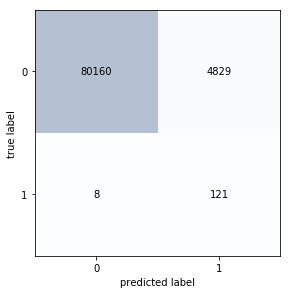

oversample test recall score:0.937984496124031


In [25]:
clf=LogisticRegression(penalty='l1',C=best_c,solver='liblinear')
clf.fit(x_train_undersample,y_train_undersample)
y_pred=clf.predict(x_test)

mat=confusion_matrix(y_test,y_pred)
test_rec=recall_score(y_test,y_pred)

plot_confusion_matrix(mat,[0,1])
plt.show()
print('oversample test recall score:{}'.format(test_rec))

由上图可知，误分减少了1w样本左右，同时有较高的recall分数。故在样本极不均衡的情况下，经常采用过采样。

In [26]:
# 打印准确率
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9431730068845603
